In [1]:
from helperFunctions import *
from constants import *


In [2]:
# Load XDF File

"""
Files that work
marker_only.xdf
sub-P001_ses-S001_task-T1_run-001_eeg.xdf
mindwave.xdf
part_P001_block_S001.xdf

"""
filename = "part_P001_block_S001"

XDF_Path = "./data/"+filename+".xdf"
XDF_Data = loadxdf(XDF_Path)


In [3]:
print(sum(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,3]), "blinks")

0.0 blinks


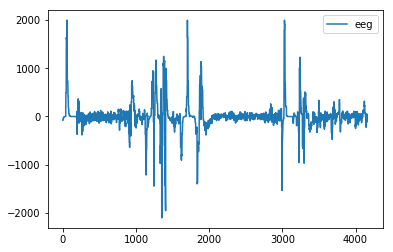

In [4]:
plt.plot(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,0], label="eeg")
plt.legend()
plt.show()

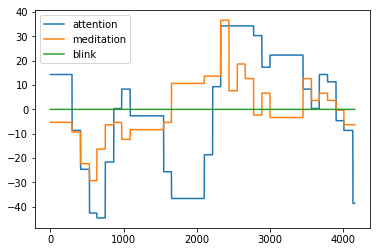

In [5]:
plt.plot(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,1], label="attention")
plt.plot(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,2], label="meditation")
plt.plot(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,3], label="blink")
plt.legend()
plt.show()
